In [994]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
path = "/Users/eliassovikgunnarsson/Downloads/vix-daily_csv.csv"
df = pd.read_csv(path, header = 0, index_col= 0)
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


<AxesSubplot: xlabel='Date'>

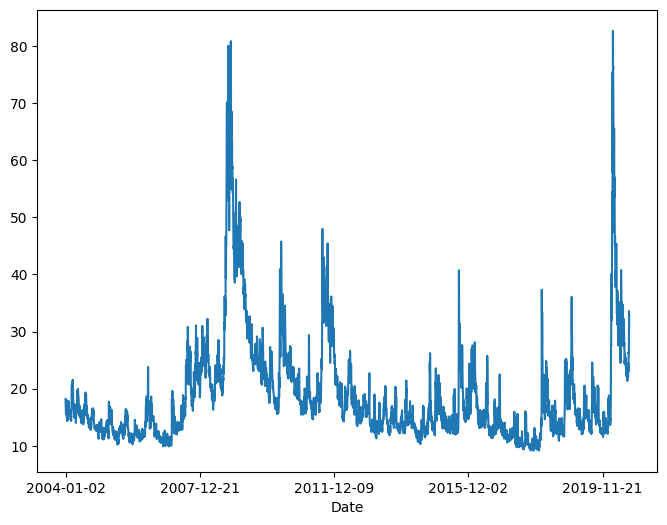

In [995]:
df['VIX Close'].plot()

#### References
* [How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
* [Omphalos, Uber’s Parallel and Language-Extensible Time Series Backtesting Tool](https://www.uber.com/en-NO/blog/omphalos/)
* [Walk-Forward Analysis Demonstration with backtrader](https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/)

In applied machine learning, we often split our data into a train and test set: the training set used to prepare the model and the test set used to evaluate it. We may evven use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model. **These models cannot be directly udes twith time series data.** This is because they assume that there is no relationship between the observations, that each observation is independent.

### Walk Forward Validation
In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time steps. We can evaluate our machine learning models under this assumption. This procedure applies two types of backtesting: sliding window and expanding window. While both have their applicable use cases, the sliding window work achieves favorable balance between model accuracy and training time [especially when it comes to testing high frequency data such as daily and hourly time series.](https://www.uber.com/en-NO/blog/omphalos/) The expanding wondow form, on the other hand is used more often in weekly, monthly or quarterly time series where the number of historical pointa are limited.

##### Sliding window
The sliding window method requires three hyperparameters: training window size, forecasting window size (horizon), and sliding steps:
* Training window size: The number of data points included in a training pass
* Forecasting window size: the number of data points to include in forecasting
* Sliding steps: the number of data points skipped from one pass to another

![image info](images/sliding_window.png)

The build in TimeSeriesSplit from sklearn.model_selection is limited to an expanding window

In [996]:
from sklearn.model_selection import TimeSeriesSplit
X = df['VIX Close']
cv = TimeSeriesSplit(n_splits=5, gap=200)

[Visualizing cross-validation behavior](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

In [997]:
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, ax, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    n_samples = len(X)
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
    # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
            )
            
    # Formatting
    yticklabels = list(range(cv.n_splits))
    ax.set(
        yticks=np.arange(cv.n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[cv.n_splits + 0.2, -0.2],
        xlim=[0,n_samples + n_samples * 0.05],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

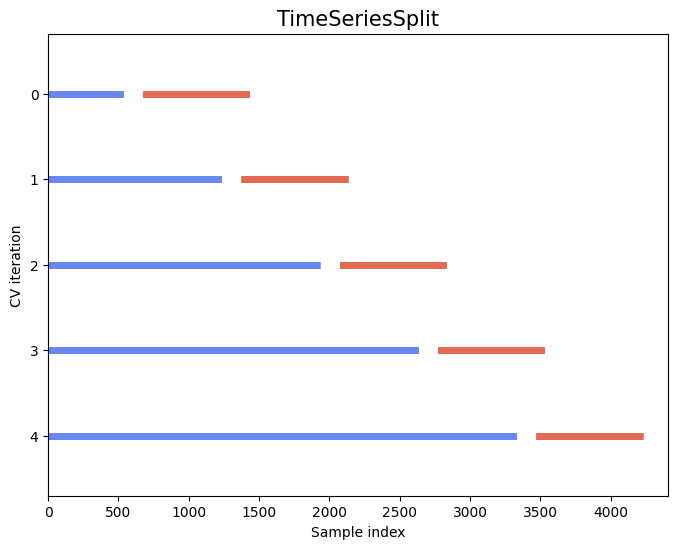

In [998]:
fig, ax = plt.subplots()
plot_cv_indices(cv, X, ax, n_splits)
plt.show()

The build in TimeSeriesSplit class from sklearn.model_selection can be modified to a sliding window

In [999]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np
 
class TimeSeriesSplitSliding(TimeSeriesSplit):
    """Time Series cross-validator slightly modified from:
    https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/ 
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    """

    def __init__(self, gap_size=0, train_splits=1, test_splits=1, fixed_length=False, **kwargs):
        super().__init__(**kwargs)
        self.gap_size = gap_size #TODO
        self.train_splits = train_splits
        self.test_splits = test_splits
        self.fixed_length = fixed_length

 
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        train_splits = self.train_splits
        test_splits = self.test_splits
        fixed_length = self.fixed_length
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if (n_folds - train_splits - test_splits) == 0 and (test_splits > 0):
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // (n_folds + (train_splits + test_splits) - 2))
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start], indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start], indices[test_start:test_start + test_size])

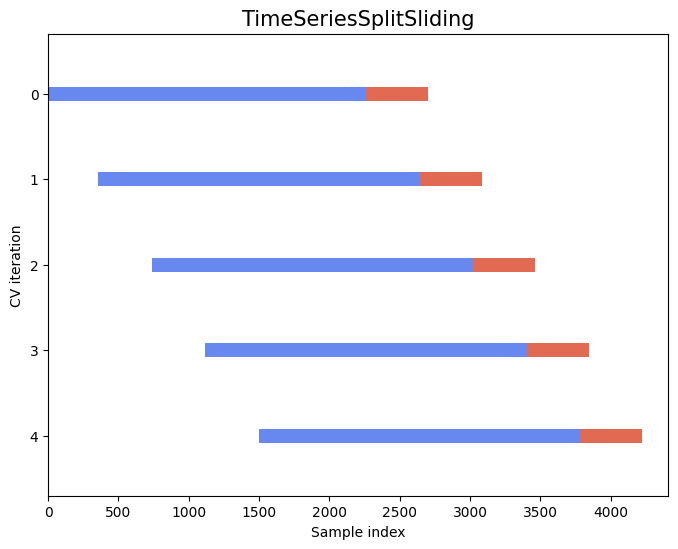

In [1000]:
tscv = TimeSeriesSplitSliding(n_splits=5, train_splits=6, test_splits = 1, fixed_length=True)
fig, ax = plt.subplots()
plot_cv_indices(tscv, X, ax)
plt.show()

### Data Windowing

In [1001]:
df.columns

Index(['VIX Open', 'VIX High', 'VIX Low', 'VIX Close'], dtype='object')

In [1002]:
column_indices = {name: i for i, name in enumerate(df.columns)}

df = df.drop(['VIX Open', 'VIX High', 'VIX Low'], axis = 1)

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]



In [1003]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.train_folds = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  WindowGenerator.split_window = split_window

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example

  def plot(self, model=None, plot_col='VIX Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  WindowGenerator.plot = plot


In [1004]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['VIX Close'])
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VIX Close']

In [1005]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df[:w1.total_window_size]),
                           np.array(df[100:100+w1.total_window_size]),
                           np.array(df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 1, 1)


In [1006]:
samples = w1.make_dataset(df)
samples.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [1007]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [1008]:
MAX_EPOCHS = 200


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [1067]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, w1)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

Epoch 1/200


2023-03-02 14:11:16.096092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:16.461663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:16.815972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:17.416809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:17.727742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 413.5592 - mean_absolute_error: 17.9549

2023-03-02 14:11:21.799408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:21.929987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:22.049629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 8s 56ms/step - loss: 413.5592 - mean_absolute_error: 17.9549 - val_loss: 144.7576 - val_mean_absolute_error: 11.1630
Epoch 2/200
91/91 [==============================] - 3s 31ms/step - loss: 301.8526 - mean_absolute_error: 14.5337 - val_loss: 95.4951 - val_mean_absolute_error: 8.6862
Epoch 3/200
91/91 [==============================] - 3s 27ms/step - loss: 252.8052 - mean_absolute_error: 12.7591 - val_loss: 75.0083 - val_mean_absolute_error: 7.4181
Epoch 4/200
91/91 [==============================] - 2s 27ms/step - loss: 224.9250 - mean_absolute_error: 11.6186 - val_loss: 60.4914 - val_mean_absolute_error: 6.3640
Epoch 5/200
91/91 [==============================] - 2s 27ms/step - loss: 202.5280 - mean_absolute_error: 10.6125 - val_loss: 49.1384 - val_mean_absolute_error: 5.4019
Epoch 6/200
91/91 [==============================] - 2s 26ms/step - loss: 183.7915 - mean_absolute_error: 9.6916 - val_loss: 40.3701 - val_mean_absolute_error: 4.5963
Epo

In [1068]:
lstm_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 30, 10)            480       
                                                                 
 lstm_74 (LSTM)              (None, 10)                840       
                                                                 
 dense_52 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [1069]:
lstm_model_wide = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_wide, w1)

val_performance['LSTM_WIDE'] = lstm_model_wide.evaluate(w1.val)
performance['LSTM_WIDE'] = lstm_model_wide.evaluate(w1.test, verbose=0)

Epoch 1/200


2023-03-02 14:11:58.205502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:58.483547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:11:58.934566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 220.2136 - mean_absolute_error: 10.6986

2023-03-02 14:12:01.851119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 14:12:01.939097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 6s 40ms/step - loss: 220.2136 - mean_absolute_error: 10.6986 - val_loss: 28.2304 - val_mean_absolute_error: 4.4693
Epoch 2/200
91/91 [==============================] - 2s 20ms/step - loss: 95.8505 - mean_absolute_error: 6.3799 - val_loss: 30.8166 - val_mean_absolute_error: 4.8962
Epoch 3/200
91/91 [==============================] - 2s 17ms/step - loss: 74.4392 - mean_absolute_error: 5.2013 - val_loss: 19.3954 - val_mean_absolute_error: 3.7387
Epoch 4/200
91/91 [==============================] - 2s 19ms/step - loss: 54.8816 - mean_absolute_error: 4.1076 - val_loss: 15.7271 - val_mean_absolute_error: 2.8395
Epoch 5/200
91/91 [==============================] - 2s 17ms/step - loss: 44.4092 - mean_absolute_error: 3.6384 - val_loss: 15.0810 - val_mean_absolute_error: 2.6406
Epoch 6/200
91/91 [==============================] - 2s 19ms/step - loss: 37.7035 - mean_absolute_error: 3.3602 - val_loss: 14.5600 - val_mean_absolute_error: 2.6578
Epoch 7/200
91

In [1072]:
#predictions
#predictions = predictions[:,-1]

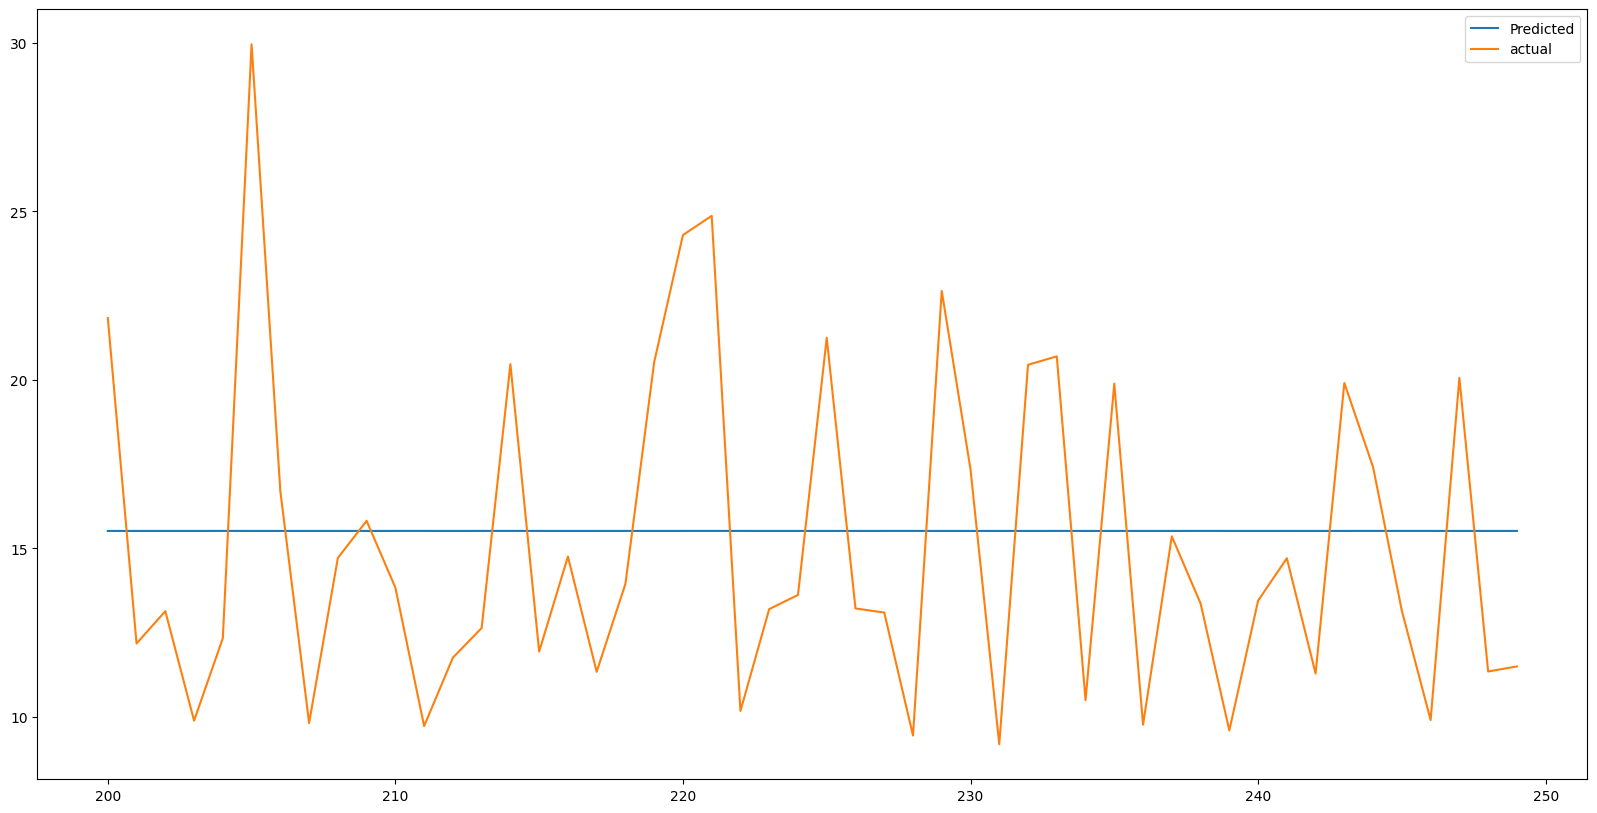

In [1076]:
predicted = predictions.flatten()
actual = y.flatten()

timesteps = np.array([i for  i in range(len(predicted))])

n = 200

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(timesteps[n:50+n], predicted[n:50+n], label = 'Predicted')
ax.plot(timesteps[n:50+n], actual[n:50+n], label = 'actual')
ax.legend()
plt.show()

In [1077]:
lstm_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 30, 10)            480       
                                                                 
 lstm_74 (LSTM)              (None, 10)                840       
                                                                 
 dense_52 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

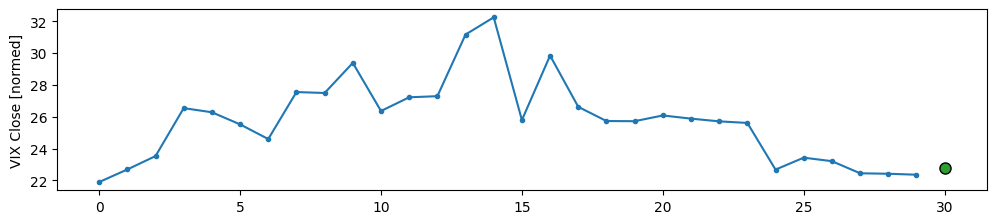

In [1078]:
w1.plot(lstm_model)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

X, y = create_dataset(X = df.drop('VIX Close', axis = 1), y = df['VIX Close'], time_steps=TIME_STEPS)